### Compare abstracts of papers in my library with new Arxiv submissions.

In [2]:
from nltk.stem import WordNetLemmatizer
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer


## self.text is a term used in linguistics meaning a large set of text body.
stop_words = set(stopwords.words("english"))
from mylibrary.Keyword_extractor import Keyword_extractor

/home/hoseung/anaconda3/envs/mylibrary/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""


## New papers

In [3]:
import requests
from lxml import etree
import mylibrary


search_results = requests.get("http://export.arxiv.org/api/query?"+
                              "search_query=cat:astro-ph.GA"+
                              "&start=0&max_results=1000"+
                              "&sortBy=submittedDate&sortOrder=descending")

alldata=[]

root = etree.fromstring(search_results.content)
for entry in root.findall("{http://www.w3.org/2005/Atom}entry"):
    self = mylibrary.Arxiv.Arxiv_meta()

    for element in entry:
        name = element.tag.split("}")[-1]
        if name == "author":
            for Echild in element.getchildren():
                self.meta[name].append(Echild.text)            
        else:
            try:
                if isinstance(self.meta[name], list):
                    try:
                        self.meta[name].append(element.attrib["term"])
                    except:
                        self.meta[name].append(element.text)
                else:
                    try:
                        self.meta[name] = element.attrib["term"]
                    except:
                        self.meta[name] = element.text
            except:
                continue
                
    alldata.append(self)

In [3]:
kwe = Keyword_extractor()
kwe.set_vectorizer(3, max_features=2000)

summed_abstract = ""
for article in alldata:
    summed_abstract += article.meta["summary"]

In [4]:
kwe.extract_words([summed_abstract])
top_100_2 = kwe.get_top_n_words(50, ngram=2)
top_100_1 = kwe.get_top_n_words(50, ngram=1)

## Old papers

In [5]:
import bibtexparser

# Extract keywords from my library
with open("Cluster_env_papers.bib", "r") as f:
    bib_db = bibtexparser.load(f)
    
summed_my_abstract = ""
for article in bib_db.entries:
    try:
        summed_my_abstract += article["abstract"]
    except:
        print("No abstract")

No abstract
No abstract


In [6]:
kwe.extract_words([summed_my_abstract])
my_top100_2 = kwe.get_top_n_words(50, ngram=2)
my_top100_1 = kwe.get_top_n_words(50, ngram=1)

In [48]:
print(top_100_1)
print(my_top100_1)

[('galaxy', 20), ('model', 16), ('star', 13), ('arm', 12), ('spiral', 11), ('result', 11), ('grain', 11), ('gas', 10), ('density', 9), ('heating', 9), ('velocity', 8), ('observed', 7), ('formation', 7), ('bulge', 7), ('also', 7), ('stellar', 7), ('data', 7), ('temperature', 7), ('distance', 7), ('two', 6), ('time', 6), ('high', 6), ('winding', 6), ('observation', 6), ('process', 6), ('dispersion', 6), ('sfr', 6), ('surface', 6), ('specie', 6), ('destruction', 6), ('induced', 6), ('scattering', 6), ('evolution', 6), ('accretion', 5), ('cosmic', 5), ('inflow', 5), ('sigma', 5), ('interstellar', 5), ('whole', 5), ('low', 5), ('effective', 5), ('extinction', 5), ('band', 5), ('binary', 5), ('suggests', 4), ('resolution', 4), ('show', 4), ('map', 4), ('correlation', 4), ('size', 4)]
[('galaxy', 143), ('cluster', 86), ('mass', 39), ('sample', 28), ('code', 25), ('stellar', 20), ('group', 20), ('distribution', 19), ('formation', 18), ('halo', 18), ('star', 18), ('gas', 17), ('simulation', 17)

## Now, I want to compare each new paper to the whole set of my library.

https://open.blogs.nytimes.com/2015/08/11/building-the-next-new-york-times-recommendation-engine/  

1. **Collaborative filtering** cannot be applied to new entries as no user rating is available. (It's true for any paper, as there is no such thing as user rating. --- maybe citation in case of old papers?)  

2. **Content-based filtering** also doesn't work very well. If I use pre-defined keywords by journals, I get too broad list of recommendations. I tried to extract more specific keywords, which means now there is no exact one-to-one correlation between keywords of different articles.  

3. Then...?

### Latent Dirichlet allocation
https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation  

LDA, an example of topic model, tries to quantify the topic of an article as a combination of *unobserved / latent 
/ hidden* smaller topics, assuming the article is made up of a few topics.  
It can be used, for example, to automatically assign a news articles into one of (culture, politics, economy, science, ...) categories. 

The name "Dirichlet" comes from the assumption that the distribution of topics has a sparse *Dirichlet* distribution. In a layman's term, this means that an article is a mixture of small number of topics, and each 
topic has a small set of characteristic/distingushing vocabularies.


#### Things to consider

Can a scientific paper be well represented by a number of sub topics? Maybe not because there is only central topic in a paper, and subtopics are further details of the central topic. This heirarchy may not be correctly captured by LDA algorithm. 

My actual thought process when determining which paper to read and which not need to be analyzed before I can go for a specific algorithm....

[LDA example 1](LDA_example_news.ipynb)

In [1]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools tailored for LDA analysis.
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import pandas as pd

In [16]:
mydata = pd.DataFrame({entry.meta["summary"] for entry in alldata})

In [20]:
mydata.columns = ["abs"]

In [27]:
data = mydata['abs'].tolist()

data = [re.sub('[^a-zA-Z]', ' ', sent) for sent in data]
data = [sent.lower() for sent in data]
data = [re.sub("(\\d|\\W)+"," ",sent) for sent in data]
data = [re.sub("backslash\w*", " ", sent) for sent in data]
data = [re.sub("\s[a-zA-Z]{1,2}\s", ' ', sent) for sent in data]

#data = [self.wnl.lemmatize(word) for word in data.split() if not word in self.stop_words]

<>:6: DeprecationWarning: invalid escape sequence \w
<>:7: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \w
<>:7: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \w
<>:7: DeprecationWarning: invalid escape sequence \s
<ipython-input-27-76a5cf527ced>:6: DeprecationWarning: invalid escape sequence \w
  data = [re.sub("backslash\w*", " ", sent) for sent in data]
<ipython-input-27-76a5cf527ced>:7: DeprecationWarning: invalid escape sequence \s
  data = [re.sub("\s[a-zA-Z]{1,2}\s", ' ', sent) for sent in data]


In [29]:
# Tokenize with Gensim
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [30]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/home/hoseung/anaconda3/envs/mylibrary/lib/python3.7/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['observations', 'show', 'that', 'multiple', 'gas', 'phases', 'can', 'coexist', 'the', 'atmospheres', 'galaxies', 'and', 'clusters', 'these', 'atmospheres', 'may', 'significantly', 'rotating', 'the', 'inner', 'parts', 'with', 'typical', 'velocities', 'that', 'approach', 'even', 'exceed', 'the', 'local', 'sound', 'speed', 'the', 'thermal', 'instability', 'natural', 'candidate', 'explain', 'the', 'formation', 'cold', 'structures', 'via', 'condensation', 'hotter', 'gas', 'phase', 'here', 'systematically', 'study', 'the', 'effect', 'rotation', 'the', 'thermal', 'stability', 'stratified', 'plane', 'parallel', 'atmospheres', 'using', 'both', 'analytical', 'arguments', 'and', 'numerical_simulations', 'find', 'that', 'the', 'formation', 'cold', 'structures', 'starting', 'from', 'small', 'isobaric', 'perturbations', 'enhanced', 'the', 'regions', 'where', 'the', 'rotation', 'the', 'system', 'dynamically', 'important', 'when', 'the', 'rotational', 'velocity', 'becomes', 'comparable', 'the', 'soun

In [31]:
def remove_stopwords(texts):
    """
    texts is iterable
    
    """
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [33]:
nlp = spacy.load('en', disable=['parser', 'ner'])

data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)

# keep only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

/home/hoseung/anaconda3/envs/mylibrary/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
/home/hoseung/anaconda3/envs/mylibrary/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)


[['observation', 'show', 'multiple', 'gas', 'phase', 'coexist', 'atmospher', 'galaxy', 'cluster', 'atmosphere', 'may', 'significantly', 'rotate', 'inner', 'part', 'typical', 'velocity', 'approach', 'even', 'exceed', 'local', 'sound', 'speed', 'thermal', 'instability', 'natural', 'candidate', 'explain', 'formation', 'cold', 'structure', 'condensation', 'hot', 'gas', 'phase', 'systematically', 'study', 'effect', 'rotation', 'thermal', 'stability', 'stratified', 'plane', 'parallel', 'atmosphere', 'use', 'analytical', 'argument', 'numerical_simulation', 'find', 'formation', 'cold', 'structure', 'start', 'small', 'isobaric', 'perturbation', 'enhance', 'region', 'rotation', 'system', 'dynamically', 'important', 'rotational', 'velocity', 'become', 'comparable', 'sound', 'speed', 'particular', 'threshold', 'value', 'ratio', 'cool', 'dynamical', 'time', 'rm', 'cool', 'dyn', 'condensation', 'form', 'increase', 'factor', 'sim', 'presence', 'significant', 'rotation', 'briefly', 'discuss', 'implica

In [34]:
# Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Corpus
texts = data_lemmatized
# Term Codument Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [35]:
def try_num_topics(dictionary, corpus, texts, n_topics=range(5,40,4)):
    """
        Note that corpus = [id2word.doc2bow(text) for text in texts].
    """
    print("Testing # topics : {}".format(n_topics))
    coherence_values=[]
    model_list = []
    
    for num_topics in n_topics:
        print("testing num_topics ={}".format(num_topics))
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=num_topics,
                                               random_state=100,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)


        coherence_model_lda = CoherenceModel(model=lda_model,
                                             texts=data_lemmatized,
                                             dictionary=dictionary,
                                             coherence='c_v')
        
        coherence_values.append(coherence_model_lda.get_coherence())
        model_list.append(lda_model)

    return model_list, coherence_values

In [37]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

models, coherence_values = try_num_topics(id2word, corpus, data_lemmatized,
                                          n_topics = range(3,30,3))

Testing # topics : range(3, 30, 3)
testing num_topics =3
testing num_topics =6
testing num_topics =9
testing num_topics =12
testing num_topics =15
testing num_topics =18
testing num_topics =21
testing num_topics =24
testing num_topics =27


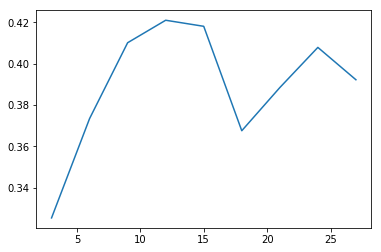

In [38]:
plt.plot(range(3,30,3), 
         coherence_values)

In [39]:
best = models[3]

In [41]:
# Visualize the topics. Very useful!
# It takse some time...
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best, corpus, id2word)
vis

/home/hoseung/anaconda3/envs/mylibrary/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.209205  0.064815       1        1  38.738434
11     0.176281  0.158771       2        1  10.165612
9      0.214660  0.004403       3        1   9.158783
1      0.102250 -0.138850       4        1   9.133370
6      0.013760 -0.173313       5        1   6.804274
7      0.029315  0.016762       6        1   5.385797
5     -0.108858  0.174740       7        1   5.139863
2     -0.024759 -0.187352       8        1   4.165111
4     -0.149842 -0.178610       9        1   3.787824
10    -0.130292  0.107904      10        1   3.071283
0     -0.141734  0.081108      11        1   2.577182
3     -0.189987  0.069622      12        1   1.872464, topic_info=     Category         Freq                Term        Total  loglift  logprob
126   Default  1598.000000                star  1598.000000  30.0000  30.0000
28    Default   825.000000                 gas   825.000000  29.0000  29.0000
27    Default  2174.000000              galaxy  2174.000000  28.0000  28.0000
149   Default   473.000000            emission   473.000000  27.0000  27.0000
118   Default   317.000000                 ray   317.000000  26.0000  26.0000
170   Default   526.000000                line   526.000000  25.0000  25.0000
271   Default   306.000000          simulation   306.000000  24.0000  24.0000
102   Default  1235.000000                mass  1235.000000  23.0000  23.0000
8     Default   601.000000             cluster   601.000000  22.0000  22.0000
338   Default   404.000000              sample   404.000000  21.0000  21.0000
127   Default   675.000000             stellar   675.000000  20.0000  20.0000
656   Default   270.000000               cloud   270.000000  19.0000  19.0000
131   Default   361.000000              survey   361.000000  18.0000  18.0000
50    Default   433.000000              region   433.000000  17.0000  17.0000
193   Default   292.000000               radio   292.000000  16.0000  16.0000
26    Default   743.000000           formation   743.000000  15.0000  15.0000
119   Default   405.000000            redshift   405.000000  14.0000  14.0000
79    Default   222.000000          black_hole   222.000000  13.0000  13.0000
204   Default   361.000000              source   361.000000  12.0000  12.0000
863   Default   207.000000             outflow   207.000000  11.0000  11.0000
74    Default   787.000000                 use   787.000000  10.0000  10.0000
679   Default   266.000000           molecular   266.000000   9.0000   9.0000
94    Default   324.000000                halo   324.000000   8.0000   8.0000
253   Default   717.000000               model   717.000000   7.0000   7.0000
145   Default   334.000000               datum   334.000000   6.0000   6.0000
1034  Default   221.000000         metallicity   221.000000   5.0000   5.0000
1194  Default   140.000000           satellite   140.000000   4.0000   4.0000
153   Default   306.000000               field   306.000000   3.0000   3.0000
425   Default   142.000000         dark_matter   142.000000   2.0000   2.0000
25    Default   394.000000                form   394.000000   1.0000   1.0000
...       ...          ...                 ...          ...      ...      ...
4154  Topic12    12.441406           enceladus    13.278952   3.9128  -5.1578
3085  Topic12    10.581470          appearance    11.419080   3.9017  -5.3198
1522  Topic12    10.576470          subcluster    11.414086   3.9017  -5.3202
3040  Topic12    10.450974             collide    11.288559   3.9008  -5.3322
751   Topic12    77.004837              stream    83.542976   3.8964  -3.3350
2014  Topic12     9.798215              helium    10.635760   3.8959  -5.3967
2037  Topic12     8.982368               refer     9.819972   3.8888  -5.4836
1516  Topic12     8.295566                mach     9.133121   3.8817  -5.5632
5840  Topic12     8.053225             barnard     8.890787   3.8790  -5.5928
309

## words to further remove

kpc, myr, gyr, may, erg, mjy, ...

In [42]:
def format_topics(ldamodel, corpus, texts):
    topic_df = pd.DataFrame()
    
    for i, row in enumerate(ldamodel[corpus]):
        # sort by weight
        row = sorted(row[0], key=lambda x: x[1], reverse=True)

        # Dominant topic of each document. Keywords
        topic_num, prop_topic = row[0]
        topic_keywords = ", ".join([word for word, prop in ldamodel.show_topic(topic_num)])
        topic_df = topic_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
        # ignore_index : 

    topic_df.columns = ["Dominant_Topic", 'Contribution', 'keywords']

    # Add original text
    topic_df = pd.concat([topic_df, pd.Series(texts)], axis=1)
    return topic_df

In [46]:
df_topic_keywords = format_topics(best, corpus, texts)
df_dominant_topic = df_topic_keywords.reset_index()

#df_dominant_topic.columns = ["Dominant_Topic", 'Contribution', 'Keywords']
df_dominant_topic.head(100)

,index,Dominant_Topic,Contribution,keywords,0
0,0,8.0,0.7946,"galaxy, mass, star, find, gas, use, formation,...","[observation, show, multiple, gas, phase, coex..."
1,1,8.0,0.4474,"galaxy, mass, star, find, gas, use, formation,...","[optical, ray, observation, strongly, gravitat..."
2,2,8.0,0.7120,"galaxy, mass, star, find, gas, use, formation,...","[present, multiwavelength, study, megamaser, g..."
3,3,7.0,0.4385,"black_hole, binary, merger, evolution, accreti...","[merger, black_hole, neutron, star, binary, ex..."
4,4,1.0,0.4033,"quasar, galaxy, observation, line, high, large...","[report, discovery, active_galactic, nucleus, ..."
5,5,9.0,0.3207,"galaxy, sample, redshift, mass, find, use, alp...","[use, classification, provide, citizen, scient..."
6,6,8.0,0.6185,"galaxy, mass, star, find, gas, use, formation,...","[study, planck, microwave, temperature, map, s..."
7,7,8.0,0.8103,"galaxy, mass, star, find, gas, use, formation,...","[exploit, sample, galaxy, draw, xxl, multiwave..."
8,8,10.0,0.4765,"particle, potential, model, force, density, or...","[introduce, method, dynamic, mode, decompositi..."
9,9,8.0,0.6517,"galaxy, mass, star, find, gas, use, formation,...","[combination, precise, radial, velocity, multi..."
